# Visual proprioception experiments

Experiments investigating various configurations for the visual proprioception of the robot. 

In [1]:
import sys
sys.path.append("..")
from settings import Config

import pathlib
from pprint import pprint
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

# from behavior_cloning.demo_to_trainingdata import BCDemonstration
from sensorprocessing import sp_conv_vae, sp_cnn
# from robot.al5d_position_controller import RobotPosition

from visual_proprioception.visproprio_helper import load_demonstrations_as_proprioception_training
from visual_proprioception.visproprio_models import VisProprio_SimpleMLPRegression


Loading pointer config file: C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
Loading machine-specific config file: G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml


In [2]:
# run = "vae_mlp_00"
run = "vgg19_mpl_00"
exp = Config().get_experiment("visual_proprioception", run)
pprint(exp)

if exp["sensor_processing"] == "vae":
    spexp = Config().get_experiment(
        exp['sp_experiment'], exp['sp_run'])
    sp = sp_conv_vae.get_sp_of_conv_vae_experiment(exp['sp_run'])
if exp['sensor_processing'] == "vgg19":
    spexp = Config().get_experiment("sp_cnn", "vgg19_orig")
    sp = sp_cnn.VGG19SensorProcessing(spexp)


Missing experiment system dependent config file G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\visual_proprioception\vae_mlp_00_sysdep.yaml, that is ok, proceeding.
Configuration for experiment: visual_proprioception/vae_mlp_00 successfully loaded
{'data_dir': WindowsPath('c:/Users/lboloni/Documents/Code/_TempData/BerryPicker-experiments/visual_proprioception/vae_mlp_00'),
 'encoding_size': 256,
 'epochs': 30,
 'group_name': 'visual_proprioception',
 'output_size': 6,
 'proprioception_input_file': 'train_inputs.pt',
 'proprioception_mlp_model_file': 'proprioception_mlp.pth',
 'proprioception_target_file': 'train_targets.pt',
 'proprioception_test_input_file': 'test_inputs.pt',
 'proprioception_test_target_file': 'test_targets.pt',
 'proprioception_testing_task': 'random-uncluttered-test',
 'proprioception_training_task': 'random-uncluttered',
 'regressor_hidden_size_1': 64,
 'regressor_hidden_size_2': 64,
 'run_name': 'vae_mlp_00',
 'sensor

c:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\exploratory_experiments\..\sensorprocessing\sp_conv_vae.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.

VanillaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Se

In [3]:
task = exp["proprioception_training_task"]
proprioception_input_file = pathlib.Path(
    exp["data_dir"], exp["proprioception_input_file"])
proprioception_target_file = pathlib.Path(
    exp["data_dir"], exp["proprioception_target_file"])
tr = load_demonstrations_as_proprioception_training(
    sp, task, proprioception_input_file, proprioception_target_file)
inputs_training = tr["inputs_training"]
targets_training = tr["targets_training"]
inputs_validation = tr["inputs_validation"]
targets_validation = tr["targets_validation"]

# Initialize model, loss function, and optimizer
#input_size = inputs_training.size(1)
#hidden_size = 64
#output_size = targets_training.size(1)


# print(input_size)
# print(output_size)

model = VisProprio_SimpleMLPRegression(exp)
# criterion = nn.MSELoss()
# Experiment: would this be better???
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Cameras found: ['dev2']
There are 596 steps in this demonstration
This demonstration was recorded by the following cameras: ['dev2']
{'actiontype': 'rc-position-target',
 'camera': 'dev2',
 'cameras': ['dev2'],
 'maxsteps': 596,
 'sensorprocessor': <sensorprocessing.sp_conv_vae.ConvVaeSensorProcessing object at 0x000002E391C6AED0>,
 'source_dir': WindowsPath('C:/Users/lboloni/Documents/Code/_TempData/BerryPicker-demos/demos/random-uncluttered/2024_12_26__16_40_20'),
 'trim_from': 1,
 'trim_to': 596}
(595, 256)
(595, 6)
(595, 256)
(595, 6)
Cameras found: ['dev2']
There are 388 steps in this demonstration
This demonstration was recorded by the following cameras: ['dev2']
{'actiontype': 'rc-position-target',
 'camera': 'dev2',
 'cameras': ['dev2'],
 'maxsteps': 388,
 'sensorprocessor': <sensorprocessing.sp_conv_vae.ConvVaeSensorProcessing object at 0x000002E391C6AED0>,
 'source_dir': WindowsPath('C:/Users/lboloni/Documents/Code/_TempData/BerryPicker-demos/demos/random-uncluttered/2024_12_

In [4]:
# Create DataLoaders for batching
batch_size = 32
train_dataset = TensorDataset(inputs_training, targets_training)
test_dataset = TensorDataset(inputs_validation, targets_validation)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
def train_and_save_proprioception_model(modelfile, epochs=20):
    """Trains and saves the proprioception model
    FIXME: must have parameters etc to investigate alternative models. 
    """

    # Training loop
    num_epochs = epochs
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_X, batch_y in train_loader:
            # Forward pass
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')

    # Evaluate the model
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss:.4f}')
    torch.save(model.state_dict(), modelfile)

In [6]:
# modelfile = pathlib.Path(Config()["explorations"]["proprioception_mlp_model_file"])
modelfile = pathlib.Path(exp["data_dir"], 
                         exp["proprioception_mlp_model_file"])
epochs = exp["epochs"]
if modelfile.exists():
    model.load_state_dict(torch.load(modelfile))
else:
    train_and_save_proprioception_model(modelfile, epochs=epochs)

Epoch [10/30], Loss: 0.2046
Epoch [20/30], Loss: 0.1888
Epoch [30/30], Loss: 0.1755
Test Loss: 0.1778


In [7]:
# Checking if the reloaded model works
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')
torch.save(model.state_dict(), modelfile)

Test Loss: 0.1778


# Visualize the proprioception



In [9]:
#y = []

task = exp["proprioception_testing_task"]
proprioception_input_file = pathlib.Path(
    exp["data_dir"], exp["proprioception_test_input_file"])
proprioception_target_file = pathlib.Path(
    exp["data_dir"], exp["proprioception_test_target_file"])
tr2 = load_demonstrations_as_proprioception_training(
    sp, task, proprioception_input_file, proprioception_target_file)

inputs = tr2["inputs"] # these are actually tensors
targets = tr2["targets"]
no_from = 0
no_to = inputs.shape[0]
ypred = []
y = []
t = []
with torch.no_grad():
    for i in range(no_from, no_to):
        x = inputs[i]
        predictions = model(torch.unsqueeze(x, dim=0))
        # append the data 
        t.append(i)
        y.append(targets[i].numpy())
        ypred.append(predictions[0].numpy())

Cameras found: ['dev2']
There are 523 steps in this demonstration
This demonstration was recorded by the following cameras: ['dev2']
{'actiontype': 'rc-position-target',
 'camera': 'dev2',
 'cameras': ['dev2'],
 'maxsteps': 523,
 'sensorprocessor': <sensorprocessing.sp_conv_vae.ConvVaeSensorProcessing object at 0x000002E391C6AED0>,
 'source_dir': WindowsPath('C:/Users/lboloni/Documents/Code/_TempData/BerryPicker-demos/demos/random-uncluttered-test/2024_12_26__16_47_31'),
 'trim_from': 1,
 'trim_to': 523}
(522, 256)
(522, 6)
(522, 256)
(522, 6)


In [ ]:

ypred = np.array(ypred)
y = np.array(y)
t = np.array(t)


Create a graph with the six degrees of freedom, predicted and real value

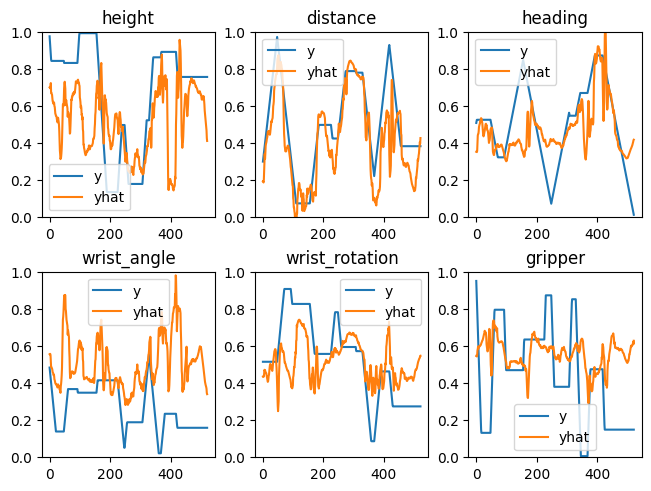

In [13]:
fig, axs = plt.subplots(2,3, constrained_layout=True)
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(Config()["robot"]["action_space_size"]):
    ax = axs[i//3, i%3] 
    ax.set_ylim(0, 1)
    ax.plot(t, y[:,i], label="y")
    ax.plot(t, ypred[:,i], label="yhat")
    ax.legend()
    ax.set_title(titles[i])

graphfilename = pathlib.Path(exp["data_dir"], "proprio_error.pdf")
plt.savefig(graphfilename)


In [13]:
POS_MAX = {"height": 5.0, "distance": 10.0, "heading": 90.0, 
               "wrist_angle": 90.0, "wrist_rotation": 75.0 + 90.0, 
               "gripper": 100}

In [ ]:
for i, fld in enumerate(POS_MAX):
    print(i, fld)